# Urban Air Quality

Import libraries

In [118]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
# tuning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [119]:
# Load files
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
sample_submission = pd.read_csv('data/SampleSubmission.csv')

In [120]:
# Preview three random rows of the train set
train.sample(3)


,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,...,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
16736,HNXHLWA X 2020-03-03,2020-03-03,HNXHLWA,30.0,5.0,74.0,2563.89,296,12.106592,80.800003,0.009780,17.101465,-2.023538,-3.173642,0.000056,0.000116,-2.069415,0.130046,829865.134444,-100.739928,19.380315,-151.768885,38.775361,0.000040,6156.074219,0.000019,0.121278,228.747602,0.201377,-100.749516,19.316297,-151.779527,38.768835,0.028547,1119.784082,452.535987,829882.409693,-97.343181,19.387974,-151.759249,...,0.078669,-100.781034,19.105459,-151.802359,38.735224,0.000023,1.351429,243.876583,98747.801541,0.210159,14.144477,877.228081,92299.810693,-100.748829,19.320845,-151.777882,38.768460,0.105460,-2.069423,829865.134444,-100.739928,19.380315,-151.768885,38.775361,0.000083,0.739615,0.000031,-2.868818,0.113807,-100.763560,19.221758,-151.783893,38.748125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7155,73GXFXK X 2020-02-26,2020-02-26,73GXFXK,53.0,21.0,176.0,16696.80,96,13.300000,64.700005,0.004895,9.652917,0.073359,2.356904,0.000069,0.000131,-1.964620,0.400276,833158.702047,71.508039,17.512770,-170.928331,54.075079,0.000037,22072.637218,0.000009,0.153761,222.341974,0.628362,71.498540,17.555743,-170.939139,54.076503,0.037752,633.644659,3695.029285,833184.132719,67.784089,17.481517,-170.890588,...,0.307367,71.544115,17.373868,-170.881215,54.049539,0.000014,0.886926,2762.271849,71318.579031,0.634827,21.172216,3762.271882,62653.472950,71.498540,17.555743,-170.939139,54.076503,0.161842,-1.964632,833158.702047,71.508039,17.512770,-170.928331,54.075079,0.000521,0.243436,0.000133,-3.091389,0.311253,71.547223,17.359605,-170.877750,54.049238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5512,5KE9R9R X 2020-01-10,2020-01-10,5KE9R9R,190.0,167.0,452.0,21837.60,288,3.680000,97.859999,0.000846,-17.079816,0.114092,2.457457,0.000201,0.000529,-0.852018,0.059823,833242.315543,71.630514,1

In [121]:
# Preview three random rows of the test set
test.sample(3)

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
8615,K3G6YOA X 2020-02-16,2020-02-16,K3G6YOA,12.200000,82.800003,0.005690,8.412592,-5.234509,4.870530,0.000042,0.000097,-1.984928,0.333017,832687.724065,75.130817,2.097544,-168.102624,56.804204,0.000032,14416.699153,NaN,0.127625,223.656821,0.678843,75.175558,1.967716,-168.062457,56.776783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000081,0.344535,75.144183,2.242624,-168.120975,56.783368,0.000176,0.605384,7425.284692,40733.558987,0.685625,21.286601,8425.284671,35372.880386,75.175558,1.967716,-168.062457,56.776783,0.248548,-1.873632,832679.622222,75.174898,1.971843,-168.062606,56.775469,-0.000323,0.139968,-0.000039,-2.665709,0.394194,75.137683,2.137598,-168.104747,56.792736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1192,4DOKYIS X 2020-04-03,2020-04-03,4DOKYIS,9.900001,83.900002,0.007700,12.942560,0.669441,4.168384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2823.709061,72114.673685,1.000000,38.899760,3823.709070,63620.860899,-13.534580,55.968241,-32.307297,53.808290,0.290113,-0.997579,842972.089385,-13.534580,55.968241,-32.307297,53.808290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14966,XNRDN2C X 2020-02-13,2020-02-13,XNRDN2C,8.700000,60.200001,0.002749,2.703088,1.175288,1.674819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138680,226.252238,0.999081,58.126059,45.916008,-175.750027,55.497462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6398.617966,44407.919744,1.000000,64.035909,7398.617965,38675.796821,58.126059,45.916008,-175.750027,55.497

In [122]:
# Preview the first five rows of the sample submission file
sample_submission.sample(5)


,Place_ID X Date,target
4547,BLADFSG X 2020-02-02,0
4042,B0BNTM9 X 2020-03-28,0
9367,MDMU646 X 2020-01-23,0
9332,M9Z8DED X 2020-03-22,0
4429,BHHB4KK X 2020-01-09,0


## 1. Exploratory Data Analysis

### 1.1. Shape analysis

In [124]:
# dataset shape
train.shape

(30557, 82)

In [131]:
test.shape

(16136, 77)

This dataset contains 30.557 rows and 82 columns

In [125]:
# variables types analysis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

We have 3 qualitative variables and 79 quantitative variables

In [51]:
# qualitative variables analysis
train.select_dtypes(include='object').describe()

,Place_ID X Date,Date,Place_ID
count,30557,30557,30557
unique,30557,94,340
top,010Q650 X 2020-01-02,2020-02-04,010Q650
freq,1,334,94


Column 'Place_ID X Date' is a combination of the two columns 'Date' and 'Place_ID'. Subsequently, it will be deleted.

In [53]:
# quantitative variables analysis
train.select_dtypes(include='number').describe()

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
count,30557.000000,30557.000000,30557.000000,3.055700e+04,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,28368.000000,28368.000000,28368.000000,28368.000000,28368.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,21888.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,2.313200e+04,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,29035.000000,29035.000000,30183.000000,29035.000000,29035.000000,29035.000000,30183.000000,30183.000000,30183.000000,30183.000000,29035.000000,30360.000000,30360.000000,30360.000000,30360.000000,30360.000000,30360.000000,23320.000000,23320.000000,23320.000000,23249.000000,23320.000000,23320.000000,23320.000000,23320.000000,23320.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,61.148045,29.025866,117.992234,7.983756e+03,125.831135,15.302326,70.552747,0.006004,9.321342,0.416886,0.088486,0.000094,0.000163,-1.093982,0.278011,755880.302425,-10.597347,32.764304,-111.413784,44.432617,0.000032,13342.570998,0.000056,0.139533,222.293932,0.423740,-11.308360,35.727367,-117.739509,47.752032,0.036230,983.448217,1438.006332,821611.615359,-12.590815,35.009648,-124.192829,47.605340,4.320685e-05,0.199705,-14.127472,35.849977,-122.640817,46.802819,0.000088,1.064105,2510.989311,77491.774334,0.433513,18.201564,3286.134009,70799.498221,-11.556380,36.520395,-120.055549,48.584734,0.226843,-1.161213,832553.776969,-11.152614,36.667009,-118.855468,48.752878,0.000113,0.429221,0.000032,-1.

Missing values analysis

In [126]:
missing_percent = train.isna().sum() * 100 / len(train)
missing_percent

Place_ID X Date                  0.00000
Date                             0.00000
Place_ID                         0.00000
target                           0.00000
target_min                       0.00000
                                  ...   
L3_CH4_aerosol_optical_depth    81.04526
L3_CH4_sensor_azimuth_angle     81.04526
L3_CH4_sensor_zenith_angle      81.04526
L3_CH4_solar_azimuth_angle      81.04526
L3_CH4_solar_zenith_angle       81.04526
Length: 82, dtype: float64

In [143]:
missing = test.isna().sum() * 100 / len(test)
missing

Place_ID X Date                          0.00000
Date                                     0.00000
Place_ID                                 0.00000
precipitable_water_entire_atmosphere     0.00000
relative_humidity_2m_above_ground        0.00000
                                          ...   
L3_CH4_aerosol_optical_depth            80.69534
L3_CH4_sensor_azimuth_angle             80.69534
L3_CH4_sensor_zenith_angle              80.69534
L3_CH4_solar_azimuth_angle              80.69534
L3_CH4_solar_zenith_angle               80.69534
Length: 77, dtype: float64

### 1.2. Subsantive analysis

Target visualization

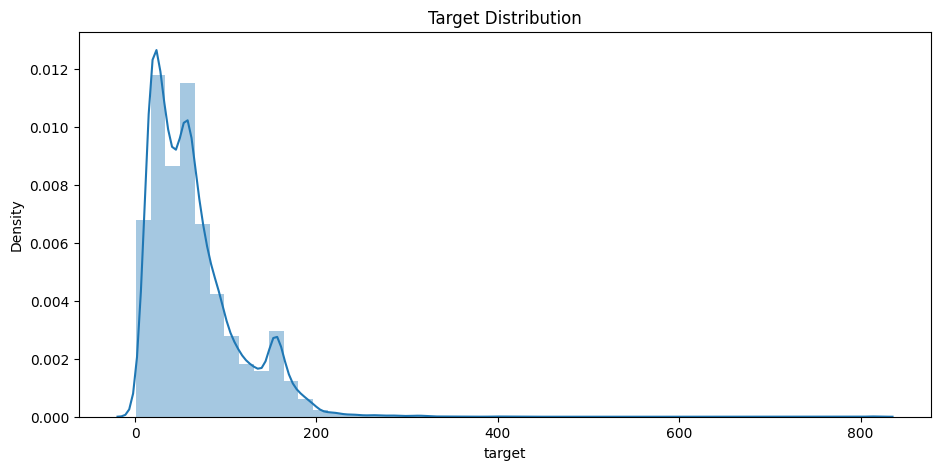

In [129]:
# target distribution
plt.figure(figsize=(11, 5))
sns.distplot(train['target'])
plt.title('Target Distribution')
plt.show()

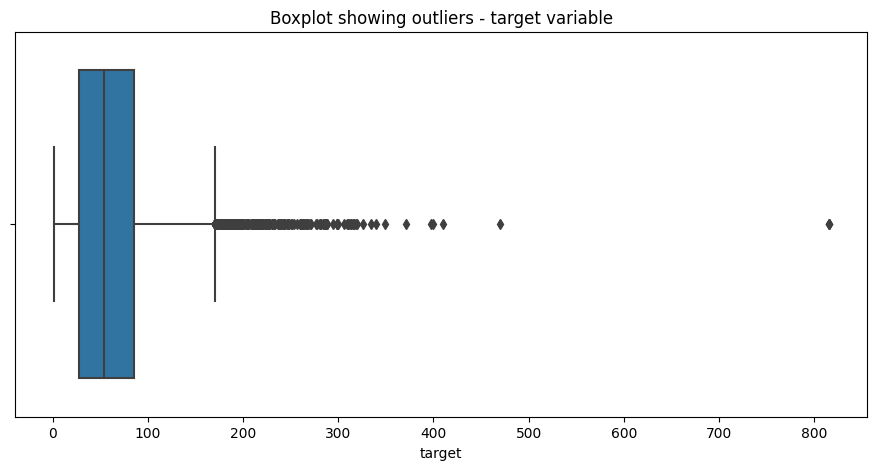

In [130]:
# Check for outliers in the target variable
plt.figure(figsize=(11, 5))
sns.boxplot(x=train['target'])
plt.title('Boxplot showing outliers - target variable')
plt.show()

## 2. Pre-processing

Elimination of outliers

Gestion des valeurs manquantes

## 3. Modelling

In [156]:
# Select X and y features for modelling
X = train.drop(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min', 'target_max', 'target_variance',	'target_count'], axis=1)
y = train['target']

In [185]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

# 1  -  29.05508850016363
# 10  -  28.957431239411605
# 19  -  28.88381514679027

Local RMSE: 30.480940959017776


In [158]:
X.shape

(30557, 74)

In [87]:
def index_min_value(d):
    if len(d) == 0:
        return None
    else:
        min_key = min(d, key=d.get)
        return min_key

In [189]:
scores_gbcs = []
model = XGBRegressor()
for i in range(41,51):
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=i)
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	metrique = mean_squared_error(y_test, y_pred, squared=False)
	scores_gbcs.append(metrique)
	print(i, ' - ', metrique)

41  -  29.32230580598496
42  -  30.480940959017776
43  -  28.388259533129787
44  -  28.826391125074448
45  -  29.33766347896291
46  -  32.78457046813427
47  -  28.04596557684737
48  -  28.634628244208052
49  -  29.80589537151935
50  -  28.989959740514866


## 4. Submission

In [186]:
# Make predictions on the test set
test_df = test.drop(['Place_ID X Date', 'Date', 'Place_ID'], axis=1)
predictions = model.predict(test_df)

Creating the submission file

In [187]:
# Create a csv file
from datetime import datetime as dt

# Create submission file
submission = pd.DataFrame({'Place_ID X Date': test['Place_ID X Date'], 'target': predictions})

submission.to_csv(f'soumissions/submission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)

In [188]:
# Preview submission file
submission.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,36.418682
1,0OS9LVX X 2020-01-03,36.143620
2,0OS9LVX X 2020-01-04,48.683990
3,0OS9LVX X 2020-01-05,30.264694
4,0OS9LVX X 2020-01-06,16.444502
